# Getting Started with COD

## Setup

In [1]:
from cloud_optimized_dicom.cod_object import CODObject
from cloud_optimized_dicom.instance import Instance
from cloud_optimized_dicom.utils import delete_uploaded_blobs
from cloud_optimized_dicom.dicomweb import handle_request
from google.cloud import storage
import pydicom
import tempfile
import os
import matplotlib.pyplot as plt

assert hasattr(CODObject, "get_instances")

client = storage.Client()

datastore_path = "gs://cod-test-bucket/test-datastore/v1.0/dicomweb"
deid_datastore_path = "gs://cod-test-bucket/test-datastore-deid/v1.0/dicomweb"

test_data_dir = os.path.join(os.path.abspath(""), "cloud_optimized_dicom", "tests", "test_data")
assert os.path.isdir(test_data_dir)
instance_a_uri = os.path.join(test_data_dir, "series", "1.2.826.0.1.3680043.8.498.22997958494980951977704130269567444795.dcm")
instance_b_uri = os.path.join(test_data_dir, "series", "1.2.826.0.1.3680043.8.498.28109707839310833322020505651875585013.dcm")
instance_c_uri = os.path.join(test_data_dir, "series", "1.2.826.0.1.3680043.8.498.33347096455284694650050230139909637623.dcm")

## Create a COD Object from scratch

In [2]:
# make sure the datastore is empty before we start
delete_uploaded_blobs(client=client, uris_to_delete=[datastore_path])

instance_a = Instance(instance_a_uri)
with CODObject(datastore_path=datastore_path, 
               client=client, 
               study_uid=instance_a.study_uid(), 
               series_uid=instance_a.series_uid(), 
               lock=True) as cod_obj:
    cod_obj.append(instances=[instance_a])
    cod_obj.sync()
    assert len(cod_obj.get_metadata().instances) == 1

## Append to an existing COD Object

In [3]:
instance_b = Instance(instance_b_uri)
with CODObject(datastore_path=datastore_path, 
               client=client, 
               study_uid=instance_a.study_uid(), 
               series_uid=instance_a.series_uid(), 
               lock=True) as cod_obj:
    cod_obj.append(instances=[instance_b])
    cod_obj.sync()
    # there should be 2 instances in the COD: A and B!
    assert len(cod_obj.get_metadata().instances) == 2

## Open a specific instance in pydicom from COD

In [4]:
cod_obj = CODObject(datastore_path=datastore_path, 
                    client=client, 
                    study_uid=instance_a.study_uid(), 
                    series_uid=instance_a.series_uid(), 
                    lock=False)
# get a dict of all instances in the series
print("All instances UIDs in the series: ", cod_obj.get_instances(dirty=True).keys())
# get a specific instance by uid
instance_from_uid = cod_obj.get_instance(instance_a.instance_uid(), dirty=True)
# get a specific instance by index (instances as an ordered list by InstanceNumber, SliceLocation, etc.)
second_instance = cod_obj.get_instance_by_index(1, dirty=True)
# open an instance by uid
with cod_obj.open_instance(instance_b.instance_uid(), dirty=True) as f:
    ds = pydicom.dcmread(f)
    print(f"Instance with UID {instance_b.instance_uid()} has SOPInstanceUID: {ds.SOPInstanceUID}")
# open an instance by index
with cod_obj.open_instance(1, dirty=True) as f:
    ds = pydicom.dcmread(f)
    print(f"Instance with index {1} has SOPInstanceUID: {ds.SOPInstanceUID}")
# open an instance by object
with cod_obj.open_instance(second_instance, dirty=True) as f:
    ds = pydicom.dcmread(f)
    print(f"Instance object {second_instance} has SOPInstanceUID: {ds.SOPInstanceUID}")

All instances UIDs in the series:  dict_keys(['1.2.826.0.1.3680043.8.498.25686983467200677455391333207792083612', '1.2.826.0.1.3680043.8.498.51559928123146446551440195325528927455'])
Instance with UID 1.2.826.0.1.3680043.8.498.25686983467200677455391333207792083612 has SOPInstanceUID: 1.2.826.0.1.3680043.8.498.25686983467200677455391333207792083612
Instance with index 1 has SOPInstanceUID: 1.2.826.0.1.3680043.8.498.51559928123146446551440195325528927455
Instance object Instance(uri=/var/folders/c2/zbssspdd0d95m1kv1c2z1tf80000gn/T/tmptrqawjr4_1.2.826.0.1.3680043.8.498.53683297893086086544068651189614355506/1.2.826.0.1.3680043.8.498.53683297893086086544068651189614355506.tar://instances/1.2.826.0.1.3680043.8.498.51559928123146446551440195325528927455.dcm, hashed_uids=False, instance_uid=1.2.826.0.1.3680043.8.498.51559928123146446551440195325528927455, series_uid=1.2.826.0.1.3680043.8.498.53683297893086086544068651189614355506, study_uid=1.2.826.0.1.3680043.8.498.7780586933068920304562968

## Remove an instance from COD

In [5]:
# remove is really just syntactic sugar for truncate_everything_except(stuff_you_didnt_remove)

with CODObject(datastore_path=datastore_path, 
               client=client, 
               study_uid=instance_a.study_uid(), 
               series_uid=instance_a.series_uid(), 
               lock=False) as cod_obj:
    # there should be 2 instances in the COD
    assert len(cod_obj.get_metadata(dirty=True).instances) == 2
    instance = cod_obj.get_metadata(dirty=True).instances[instance_a.instance_uid()]
    cod_obj.remove(instances=[instance], dirty=True)
    # now that we removed instance a, there should be 1 instance in the COD
    assert len(cod_obj.get_metadata(dirty=True).instances) == 1
    # NOTE: we did not call cod_obj.sync() here, so this removal is only local and is not reflected in the datastore

## Truncate (or "destructive append")

In [6]:
instance_c = Instance(instance_c_uri)
with CODObject(datastore_path=datastore_path, 
               client=client, 
               study_uid=instance_a.study_uid(), 
               series_uid=instance_a.series_uid(), 
               lock=False) as cod_obj:
    # right now, COD contains instance A and instance B
    assert list(cod_obj.get_metadata(dirty=True).instances.keys()) == [instance_a.instance_uid(), instance_b.instance_uid()]
    cod_obj.truncate(instances=[instance_a, instance_c], dirty=True)
    # after truncation, COD contains instances A and C, but not B
    assert list(cod_obj.get_metadata(dirty=True).instances.keys()) == [instance_a.instance_uid(), instance_c.instance_uid()]
    # NOTE: we did not call cod_obj.sync() here, so this truncation is only local and is not reflected in the datastore

## Working with thumbnails

Generated series thumbnail with shape: (2, 128, 128, 3) ([n_frames, height, width, 3])


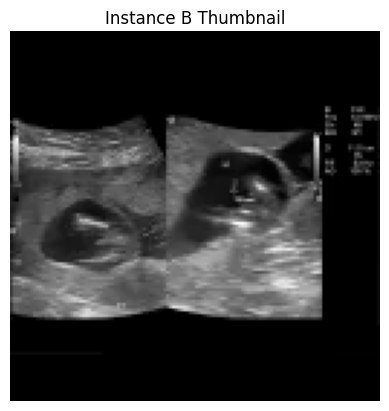

In [7]:
with CODObject(datastore_path=datastore_path, 
               client=client, 
               study_uid=instance_a.study_uid(), 
               series_uid=instance_a.series_uid(), 
               lock=False) as cod_obj:
    # generate a thumbnail
    thumbnail = cod_obj.get_thumbnail(dirty=True)
    print(f"Generated series thumbnail with shape: {thumbnail.shape} ([n_frames, height, width, 3])")
    # retrieve an instance from its index in the thumbnail (note that after sorting based on InstanceNumber, SliceLocation, etc., instance_a is the second instance in the series)
    assert cod_obj.get_instance_by_thumbnail_index(1, dirty=True) == instance_a
    # get thumbnail slice for a specific instance
    instance_b_thumbnail = cod_obj.get_thumbnail(instance_uid=instance_b.instance_uid(), dirty=True)
    plt.imshow(instance_b_thumbnail)
    plt.title("Instance B Thumbnail")
    plt.axis("off")
    plt.show()


## Working with custom metadata fields

In [8]:
with CODObject(datastore_path=datastore_path, 
               client=client, 
               study_uid=instance_a.study_uid(), 
               series_uid=instance_a.series_uid(), 
               lock=False) as cod_obj:
    # add a custom metadata field
    cod_obj.add_metadata_field(field_name="my_field", field_value="my_value", dirty=True)
    assert cod_obj.get_metadata_field(field_name="my_field", dirty=True) == "my_value"
    # remove the custom metadata field
    cod_obj.remove_metadata_field(field_name="my_field", dirty=True)
    assert cod_obj.get_metadata_field(field_name="my_field", dirty=True) is None
    

## Modify and Save an instance in COD

In [10]:
# Right now when you open a cod object you are essentially opening it in read mode
# If we did want to support write mode, then the backend changes a lot
# Rather than just pulling the tar and referencing instances within the tar, 
# COD would actually extract it, which would enable the user to modify instances directly
# In write mode, metadata would basically not exist (the metadata.json would be invalid because you're changing stuff)
# When writing is over COD would truncate() the instances, which calls append(), which would re-generate the metadata

# Anyways, the above is a future TODO. For now, modifying an instance looks like this:

with CODObject(datastore_path=datastore_path, 
               client=client, 
               study_uid=instance_a.study_uid(), 
               series_uid=instance_a.series_uid(), 
               lock=False) as cod_obj:
    # fetch the tar from GCS
    cod_obj.pull_tar(dirty=True)
    instance = cod_obj.get_metadata(dirty=True).instances[instance_a.instance_uid()]
    with tempfile.NamedTemporaryFile(suffix=".dcm") as temp_file:
        # save a modified version of the instance to a temp file
        with instance.open() as f:
            ds = pydicom.dcmread(f)
            assert ds.PatientName == "GRDNB4C659BSD9NZ"
            ds.PatientName = "John Doe"
            ds.save_as(temp_file.name)
        # remove the original instance from the COD
        cod_obj.remove(instances=[instance], dirty=True)
        # append the modified instance to the COD
        cod_obj.append(instances=[Instance(temp_file.name)], dirty=True)
        # there should be 2 instances in the COD: the modified instance A, and instance B
        assert len(cod_obj.get_metadata(dirty=True).instances) == 2
    # when we open the instance, we should see the changes
    modified_instance = cod_obj.get_metadata(dirty=True).instances[instance_a.instance_uid()]
    with modified_instance.open() as f:
        ds = pydicom.dcmread(f)
        assert ds.PatientName == "John Doe"

## Interact with COD datastore via dicomweb requests

In [10]:
# series_metadata = CODObject.dicomweb(GET {datastore_path}/studies/{study_uid}/series/{series_uid}/metadata, client)

# lose the GET... later, if supported, can add options for POST, PUT, etc.

# get study-level metadata (returns a dict of study level tags)
study_metadata = handle_request(f"GET {datastore_path}/studies/{instance_a.study_uid()}/metadata", client)
assert study_metadata["00100020"]["Value"][0] == "GRDNB4C659BSD9NZ"

# get series-level metadata (returns list of instance level tag dicts)
series_metadata = handle_request(f"GET {datastore_path}/studies/{instance_a.study_uid()}/series/{instance_a.series_uid()}/metadata", client)
assert series_metadata[0]["00080018"]["Value"][0] == instance_a.instance_uid()

# get instance-level metadata (returns instance level tag dict)
instance_metadata = handle_request(f"GET {datastore_path}/studies/{instance_a.study_uid()}/series/{instance_a.series_uid()}/instances/{instance_a.instance_uid()}/metadata", client)
assert instance_metadata["00080018"]["Value"][0] == instance_a.instance_uid()

# get a frame from an instance (expect a list of raw bytes of the frame(s))
frame = handle_request(f"GET {datastore_path}/studies/{instance_a.study_uid()}/series/{instance_a.series_uid()}/instances/{instance_a.instance_uid()}/frames/1", client)
assert isinstance(frame, list)
assert len(frame) == 1
assert isinstance(frame[0], bytes)

## Create a de-identified COD from an existing COD

In [ ]:
def example_hash_function(uid: str) -> str:
    """
    Example hash function that adds 1 to the last part of the uid (i.e 1.2.3.4 becomes 1.2.3.5)
    """
    split_uid = uid.split(".")
    last_part = split_uid[-1]
    new_last_part = str(int(last_part) + 1)
    split_uid[-1] = new_last_part
    return ".".join(split_uid)

with CODObject(datastore_path=datastore_path, 
               client=client, 
               study_uid=instance_a.study_uid(), 
               series_uid=instance_a.series_uid(), 
               lock=False) as orig_cod:
    hashed_study_uid = example_hash_function(orig_cod.study_uid)
    hashed_series_uid = example_hash_function(orig_cod.series_uid)
    orig_cod.pull_tar(dirty=True)
    # get all the instances from the original COD
    instances = [i for i in orig_cod.get_metadata(dirty=True).instances.values()]
    # provide the instances with the function they should use to hash their UIDs
    for i in instances:
        i.uid_hash_func = example_hash_function
    with CODObject(datastore_path=deid_datastore_path, 
                   client=client, 
                   study_uid=hashed_study_uid, 
                   series_uid=hashed_series_uid,
                   hashed_uids=True,
                   lock=False) as deid_cod:
        # TODO: this doesnt work yet - need to extract the instances from the original tar
        deid_cod.append(instances=instances, dirty=True)
        
    

[Errno 2] No such file or directory: '/var/folders/c2/zbssspdd0d95m1kv1c2z1tf80000gn/T/tmpiie59xs7_1.2.826.0.1.3680043.8.498.53683297893086086544068651189614355506/1.2.826.0.1.3680043.8.498.53683297893086086544068651189614355506.tar://instances/1.2.826.0.1.3680043.8.498.51559928123146446551440195325528927455.dcm'
Traceback (most recent call last):
  File "/Users/cal/work/cloud_optimized_dicom/cloud_optimized_dicom/append.py", line 439, in _create_or_append_tar
    instance.append_to_series_tar(tar)
  File "/Users/cal/work/cloud_optimized_dicom/cloud_optimized_dicom/instance.py", line 317, in append_to_series_tar
    tar.add(self.dicom_uri, arcname=f"/instances/{uid_for_uri}.dcm")
  File "/opt/homebrew/Cellar/python@3.11/3.11.11/Frameworks/Python.framework/Versions/3.11/lib/python3.11/tarfile.py", line 2194, in add
    tarinfo = self.gettarinfo(name, arcname)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.11/Frameworks/Python.framework/Version

ValueError: GRADIENT_STATE_LOGS:FAILED_TO_TAR_ALL_INSTANCES:/var/folders/c2/zbssspdd0d95m1kv1c2z1tf80000gn/T/tmpiie59xs7_1.2.826.0.1.3680043.8.498.53683297893086086544068651189614355506/1.2.826.0.1.3680043.8.498.53683297893086086544068651189614355506.tar://instances/1.2.826.0.1.3680043.8.498.51559928123146446551440195325528927455.dcm
/var/folders/c2/zbssspdd0d95m1kv1c2z1tf80000gn/T/tmpiie59xs7_1.2.826.0.1.3680043.8.498.53683297893086086544068651189614355506/1.2.826.0.1.3680043.8.498.53683297893086086544068651189614355506.tar://instances/1.2.826.0.1.3680043.8.498.25686983467200677455391333207792083612.dcm